In [1]:
# !pip install cupy-cuda111

In [2]:
import alphapept.performance
import os
import time
import alphapept.settings
import alphapept.paths
import alphapept.interface
import sys
import shutil
import logging
import importlib
import alphapept.feature_finding
import numpy as np

sample = "HeLa_500ng.raw"
original_file = f"D:/willems/data/raw/{sample}"
tmp_folder = 'D:\willems\data\gpu_cpu_performance_comparison'

if os.path.exists(tmp_folder):
    shutil.rmtree(tmp_folder)

os.makedirs(tmp_folder)
shutil.copy(original_file, tmp_folder)

file_name = os.path.join(tmp_folder, sample)
settings = alphapept.settings.load_settings(alphapept.paths.DEFAULT_SETTINGS_PATH)
settings['experiment']['file_paths'] = [file_name]
settings_ = alphapept.interface.import_raw_data(settings)
base, ext = os.path.splitext(file_name)
ms_file = alphapept.io.MS_Data_File(f"{base}.ms_data.hdf", is_read_only=True)
query_data = ms_file.read_DDA_query_data()
int_data = np.array(query_data['int_list_ms1'])
f_settings = settings['features']
max_gap = f_settings['max_gap']
ppm_tol = f_settings['ppm_tol']
split_level = f_settings['split_level']
window = f_settings['smoothing_window']
large_peak = f_settings['large_peak']

min_charge = f_settings['min_charge']
max_charge = f_settings['max_charge']
seed_masses = f_settings['seed_masses']

hill_nboot_max = f_settings['hill_nboot_max']
hill_nboot = f_settings['hill_nboot']

mass_range = f_settings['mass_range']

min_correlation = f_settings['min_correlation']

2021-06-04 13:46:44> Logging to C:\Users\admin\alphapept\logs\log_20210604134644.txt.
2021-06-04 13:46:44> Platform information:
2021-06-04 13:46:44> system     - Windows
2021-06-04 13:46:44> release    - 10
2021-06-04 13:46:44> version    - 10.0.19041
2021-06-04 13:46:44> machine    - AMD64
2021-06-04 13:46:44> processor  - Intel64 Family 6 Model 85 Stepping 4, GenuineIntel
2021-06-04 13:46:44> cpu count  - 24
2021-06-04 13:46:44> ram memory - 115.3/127.7 Gb (available/total)
2021-06-04 13:46:44> 
2021-06-04 13:46:44> Python information:
2021-06-04 13:46:44> SQLAlchemy     - 1.3.22
2021-06-04 13:46:44> alphapept      - 0.3.21
2021-06-04 13:46:44> biopython      - 1.78
2021-06-04 13:46:44> click          - 7.1.2
2021-06-04 13:46:44> comtypes       - 1.1.7
2021-06-04 13:46:44> fastcore       - 1.3.5
2021-06-04 13:46:44> h5py           - 3.1.0
2021-06-04 13:46:44> lxml           - 4.6.2
2021-06-04 13:46:44> matplotlib     - 3.3.3
2021-06-04 13:46:44> nbdev          - 1.1.4
2021-06-04 13:

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-06-04 13:46:44> Processing 1 files for step raw_conversion
2021-06-04 13:46:44> File D:\willems\data\gpu_cpu_performance_comparison\HeLa_500ng has extension .raw - converting from Thermo.
2021-06-04 13:48:58> File conversion complete. Extracted 120,226 precursors.
2021-06-04 13:49:04> File conversion of file D:\willems\data\gpu_cpu_performance_comparison\HeLa_500ng.raw complete.


In [3]:
import timeit
import time

def timing_decorator(func, timings_dict, repeats=3, loops_per_repeat=1):
    def wrapper(*args, **kwargs):
        if func.__name__ not in timings_dict:
            timings_dict[func.__name__] = {}
        if alphapept.performance.COMPILATION_MODE in timings_dict[func.__name__]:
            logging.warning(
                f"{func.__name__} is already timed for {alphapept.performance.COMPILATION_MODE}"
            )
#         timings_dict[func.__name__][alphapept.performance.COMPILATION_MODE] = timeit.repeat(
#             lambda: func(*args, **kwargs),
#             number=loops_per_repeat,
#             repeat=repeats
#         )
#         return func(*args, **kwargs)
        start = time.time()
        results = func(*args, **kwargs)
        timings_dict[func.__name__][alphapept.performance.COMPILATION_MODE] = time.time() - start
        return results
    return wrapper

In [4]:
def time_feature_finding_functions(
    compilation_mode,
    timings_dict,
    repeats=3,
    loops_per_repeat=1
):
    print(f"Running feature finding functions with compilation mode '{compilation_mode}'")
    alphapept.performance.set_compilation_mode(compilation_mode)
    importlib.reload(alphapept.feature_finding)
    alphapept.feature_finding.connect_centroids_unidirection = timing_decorator(
        alphapept.feature_finding.connect_centroids_unidirection,
        timings_dict,
        repeats=3,
        loops_per_repeat=1
    )
    alphapept.feature_finding.convert_connections_to_array = timing_decorator(
        alphapept.feature_finding.convert_connections_to_array,
        timings_dict,
        repeats=3,
        loops_per_repeat=1
    )
    alphapept.feature_finding.eliminate_overarching_vertex = timing_decorator(
        alphapept.feature_finding.eliminate_overarching_vertex,
        timings_dict,
        repeats=3,
        loops_per_repeat=1
    )
    alphapept.feature_finding.path_finder = timing_decorator(
        alphapept.feature_finding.path_finder,
        timings_dict,
        repeats=3,
        loops_per_repeat=1
    )
    alphapept.feature_finding.find_path_start = timing_decorator(
        alphapept.feature_finding.find_path_start,
        timings_dict,
        repeats=3,
        loops_per_repeat=1
    )
    alphapept.feature_finding.find_path_length = timing_decorator(
        alphapept.feature_finding.find_path_length,
        timings_dict,
        repeats=3,
        loops_per_repeat=1
    )
    alphapept.feature_finding.fill_path_matrix = timing_decorator(
        alphapept.feature_finding.fill_path_matrix,
        timings_dict,
        repeats=3,
        loops_per_repeat=1
    )
        
    logging.info(f'Hill extraction with ppm_tol {ppm_tol} and max_gap {max_gap}')
    hill_ptrs, hill_data, path_node_cnt, score_median, score_std = alphapept.feature_finding.extract_hills(query_data, max_gap, ppm_tol)
    logging.info(f'Number of hills {len(hill_ptrs):,}, len = {np.mean(path_node_cnt):.2f}')

In [5]:
timings_dict = {}

time_feature_finding_functions("cuda", timings_dict)
time_feature_finding_functions("numba-multithread", timings_dict)
time_feature_finding_functions("numba", timings_dict)
time_feature_finding_functions("python", timings_dict)

Running feature finding functions with compilation mode 'cuda'
2021-06-04 13:49:04> Hill extraction with ppm_tol 8 and max_gap 2
2021-06-04 13:49:07> Number of hills 1,105,353, len = 17.35
Running feature finding functions with compilation mode 'numba-multithread'
2021-06-04 13:49:07> Hill extraction with ppm_tol 8 and max_gap 2


  0%|                                                                                            | 0/1 [02:23<?, ?it/s]


2021-06-04 13:49:13> Number of hills 1,105,353, len = 17.35
Running feature finding functions with compilation mode 'numba'
2021-06-04 13:49:13> Hill extraction with ppm_tol 8 and max_gap 2
2021-06-04 13:49:21> Number of hills 1,105,353, len = 17.35
Running feature finding functions with compilation mode 'python'
2021-06-04 13:49:21> Hill extraction with ppm_tol 8 and max_gap 2
2021-06-04 13:55:00> Number of hills 1,105,353, len = 17.35


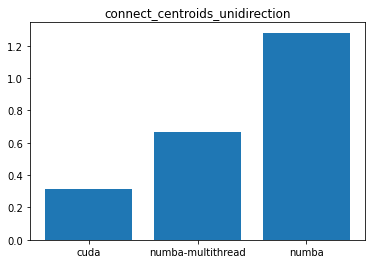

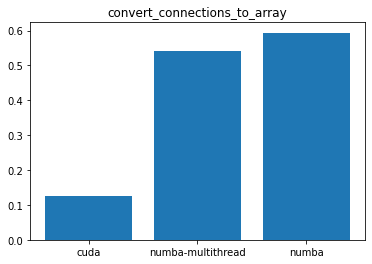

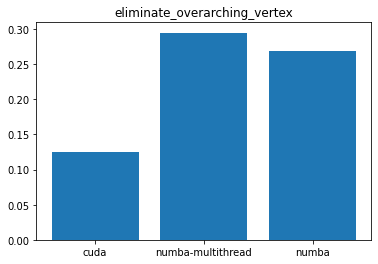

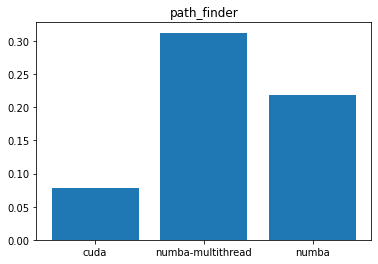

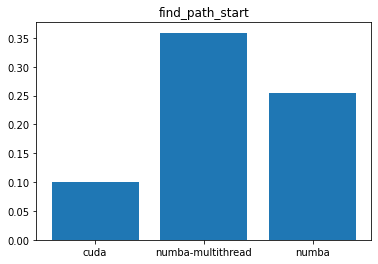

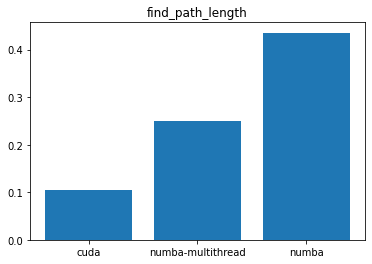

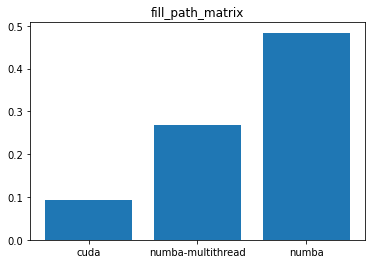

In [6]:
from matplotlib import pyplot as plt
include_python = False
for func in timings_dict:
    if not include_python:
        plt.bar(list(timings_dict[func].keys())[:-1], list(timings_dict[func].values())[:-1])
    else:
        plt.bar(list(timings_dict[func].keys()), list(timings_dict[func].values()))
    plt.title(func)
    plt.show()